The purpose of this script is to implement the inpainting algorithm described in "A one-shot inpainting algorithm based on the topological asymptotic analysis" by Auroux and Masmoudi.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la

from oneshot.get_test_image import get_test_image
from oneshot.pcolor_xy import pcolor_xy
from oneshot.poisson_solve_fipy import poisson_solve_fipy

get test image to inpaint

In [2]:
image_name = 'circle'

In [3]:
f, ismissing = get_test_image(image_name)
Nx, Ny = f.shape

display test image to inpaint

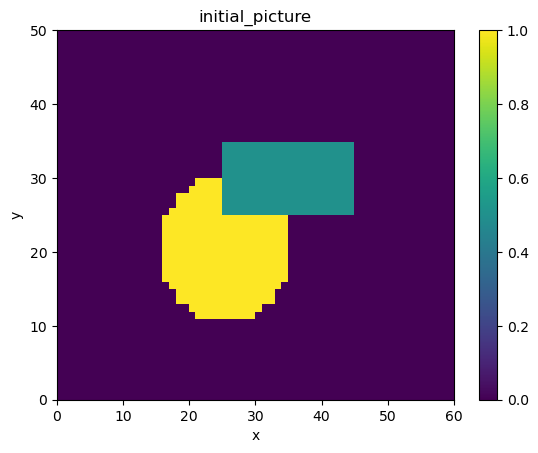

In [4]:
f2 = f.copy()
f2[ismissing] = 0.5
pcolor_xy(f2, "initial_picture")

Parameters used to build Direct and Adjoint problem

In [5]:
c0 = np.zeros([Nx, Ny])
c0[~ismissing] = 1

alpha = 1e-2

# Solving the direct and adjoint PDEs

Direct problems: computations

In [6]:
# Direct Dirichlet problem
c2_direct_d = np.ones([Nx, Ny])
c2_direct_d[~ismissing] = 0.0
u_d, u_d_x, u_d_y = poisson_solve_fipy(c0, c2_direct_d, f, pin_mask=~ismissing)
# u_d[~ismissing] = f[~ismissing]

# Direct Neumann problem
c2_direct_n = np.ones([Nx, Ny])
c2_direct_n[~ismissing] = alpha
u_n, u_n_x, u_n_y = poisson_solve_fipy(c0, c2_direct_n, f, pin_mask=None)
# u_n[~ismissing] = f[~ismissing]

# Difference between Dirichlet and Neuman solution
u_dn = u_d - u_n
u_dn[~ismissing] = 0.0

Direct problems: plots

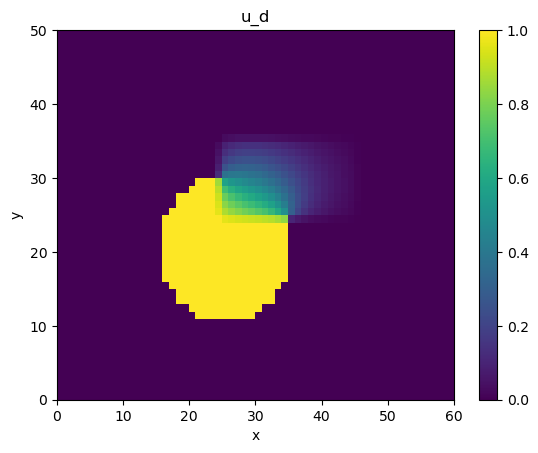

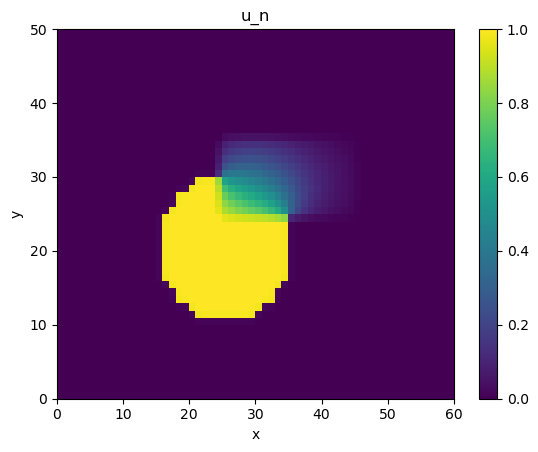

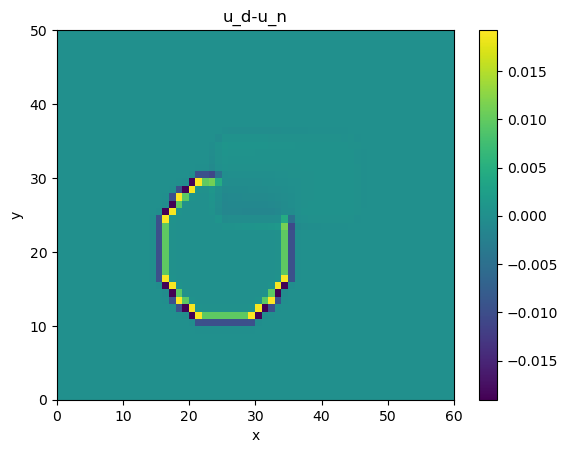

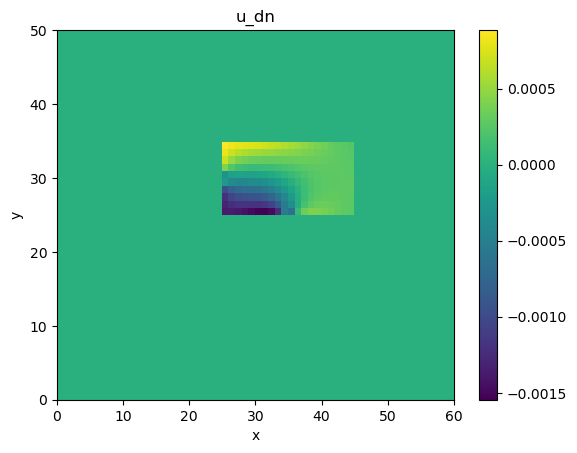

In [7]:
pcolor_xy(u_d, "u_d")
pcolor_xy(u_n, "u_n")
pcolor_xy(u_d-u_n, "u_d-u_n")
pcolor_xy(u_dn, "u_dn")

Adjoint problems: computations

In [8]:
# Adjoint Dirichlet problem
c2_adjoint_d = np.ones([Nx, Ny])
c2_adjoint_d[~ismissing] = 0.0
v_d, v_d_x, v_d_y = poisson_solve_fipy(c0, c2_adjoint_d, -u_dn, pin_mask=~ismissing)

# Adjoint Neuman problem
c2_adjoint_n = np.ones([Nx, Ny])
c2_adjoint_n[~ismissing] = alpha
v_n, v_n_x, v_n_y = poisson_solve_fipy(c0, c2_adjoint_n, u_dn, pin_mask=None)

Adjoint problems: plots

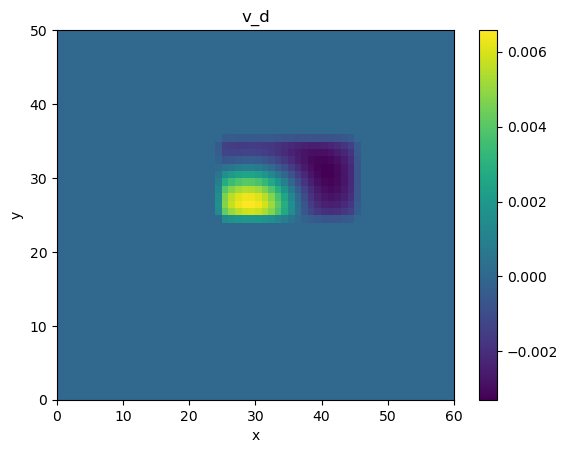

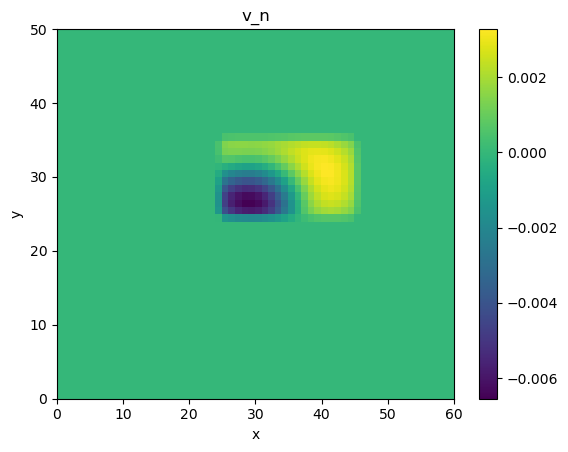

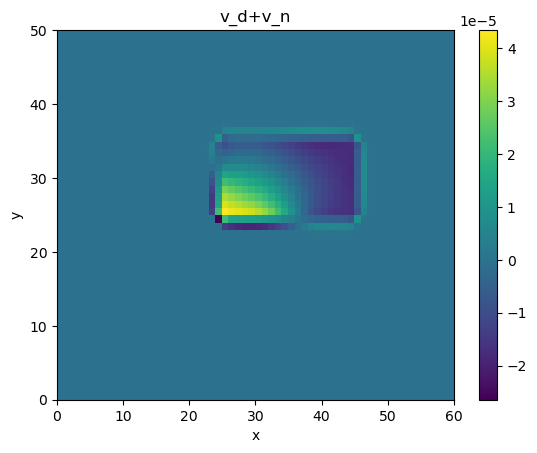

In [9]:
pcolor_xy(v_d, "v_d")
pcolor_xy(v_n, "v_n")
pcolor_xy(v_d+v_n, "v_d+v_n")

# Topological indicators : computations

In [10]:
v_d[~ismissing] = 0.0
v_n[~ismissing] = 0.0


topo_crack = np.zeros([Nx, Ny]) + np.nan
topo_hole = np.zeros([Nx, Ny]) + np.nan

for ii in range(1, Nx-1):
    for jj in range(1, Ny-1):

        if not(ismissing[ii, jj]):
            continue
        
        # gradient estimation computed by finite volume via 'fipy'
        grad_u_d = np.array([u_d_x[ii, jj], u_d_y[ii, jj]])
        grad_v_d = np.array([v_d_x[ii, jj], v_d_y[ii, jj]])
        grad_u_n = np.array([u_n_x[ii, jj], u_n_y[ii, jj]])
        grad_v_n = np.array([v_n_x[ii, jj], v_n_y[ii, jj]])

        M = -(grad_u_d.reshape([-1, 1])@grad_v_d.reshape([1, -1]) + grad_u_n.reshape([-1, 1])@grad_v_n.reshape([1, -1]))
        M = 0.5 * (M + M.T)
        eig, _ = la.eigh(M)

        # the 'crack' indicator is the indicator used in the original article
        topo_crack[ii, jj] = min(np.real(eig))

        # the 'hole' indicator is the indicator proposed by chatgpt (formula should be double cheked !)
        topo_hole[ii, jj] = - np.sum(grad_u_d*grad_v_d) + np.sum(grad_u_n*grad_v_n)

# Inpainting with the topological 'crack' indicator

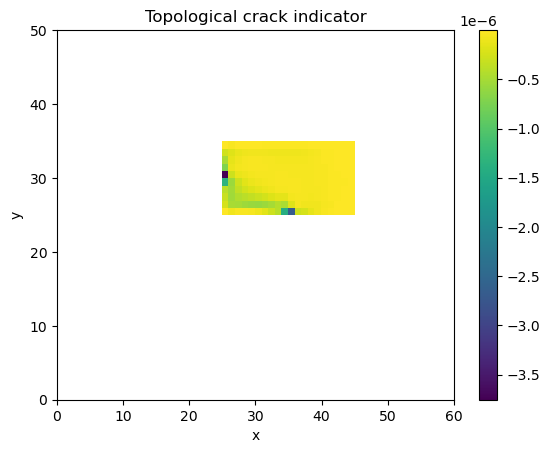

In [11]:
pcolor_xy(topo_crack, f"Topological crack indicator")

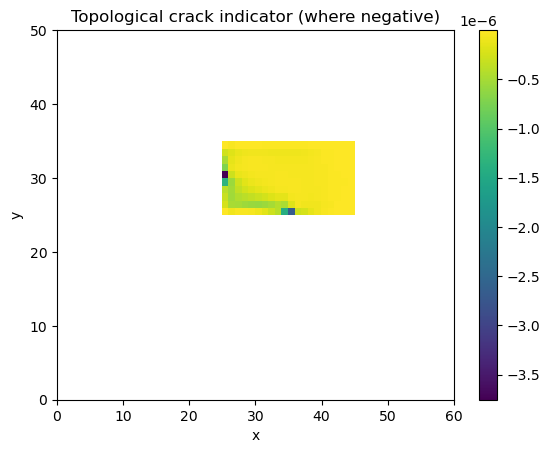

In [12]:
topo_crack_neg = topo_crack.copy()
topo_crack_neg[topo_crack_neg>=0] = np.nan
pcolor_xy(topo_crack_neg, f"Topological crack indicator (where negative)")

set the threshold value after visual inspection:

In [13]:
topo_crack_thres = -0.5e-6

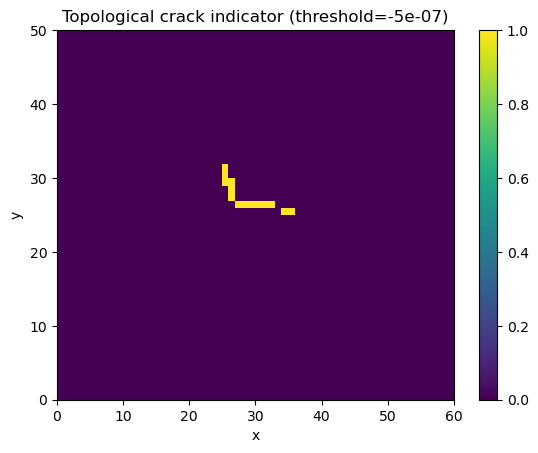

In [14]:
is_topo_crack_low = topo_crack < topo_crack_thres
pcolor_xy(is_topo_crack_low + 0.0, f'Topological crack indicator (threshold=' + str(topo_crack_thres) + ')')

Inpainting : computations

In [15]:
c2_missing = 1
c2_in = np.zeros([Nx, Ny])
c2_in[ismissing] = c2_missing
c2_in[is_topo_crack_low] = alpha

u_in, u_in_x, u_in_y =  poisson_solve_fipy(c0, c2_in, f, pin_mask=~ismissing)

Inpainting : plot

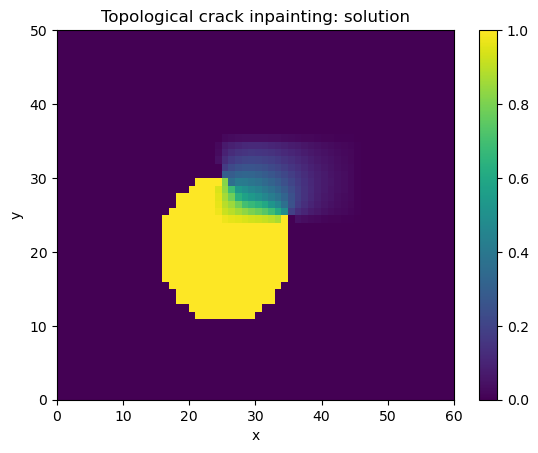

In [16]:
pcolor_xy(u_in, f"Topological crack inpainting: solution")

# Inpainting with the topological 'hole' indicator

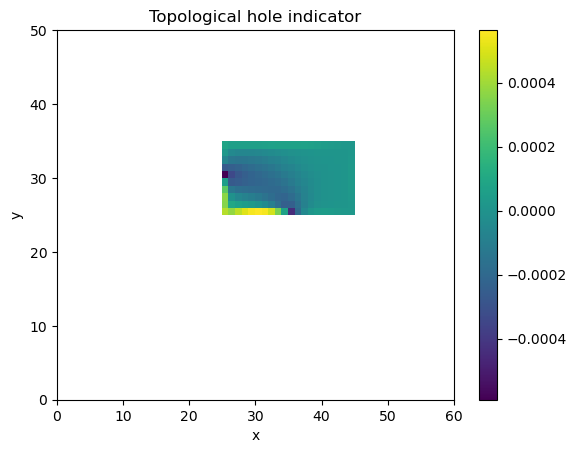

In [17]:
pcolor_xy(topo_hole, f"Topological hole indicator")

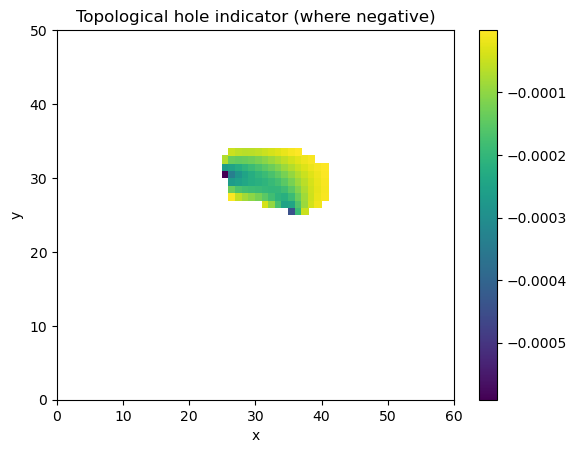

In [18]:
topo_hole_neg = topo_hole.copy()
topo_hole_neg[topo_hole_neg>=0] = np.nan
pcolor_xy(topo_hole_neg, f"Topological hole indicator (where negative)")

set the threshold value after visual inspection:

In [19]:
topo_hole_thres = -2e-4

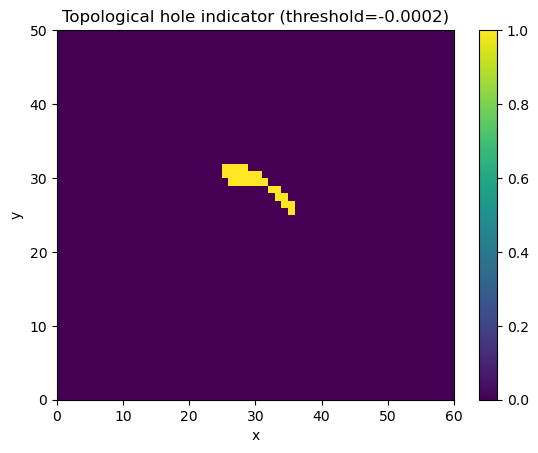

In [20]:
is_topo_hole_low = topo_hole < topo_hole_thres
pcolor_xy(is_topo_hole_low + 0.0, f'Topological hole indicator (threshold=' + str(topo_hole_thres) + ')')

Inpainting computations

In [21]:
c2_missing = 1
c2_in = np.zeros([Nx, Ny])
c2_in[ismissing] = c2_missing
c2_in[is_topo_hole_low] = alpha

u_in, u_in_x, u_in_y =  poisson_solve_fipy(c0, c2_in, f, pin_mask=~ismissing)

Inpainting : plot

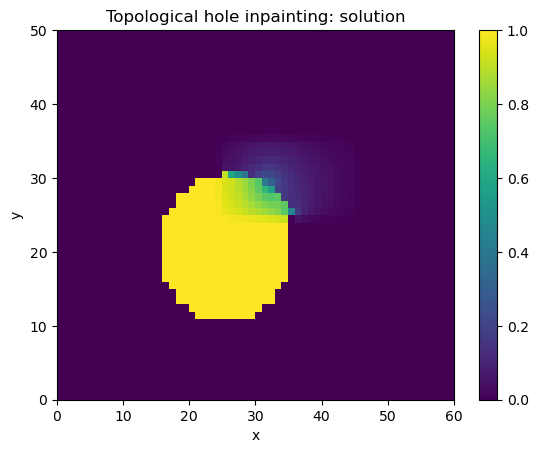

In [22]:
pcolor_xy(u_in, f"Topological hole inpainting: solution")